In [131]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from strategy import *

%matplotlib inline

In [163]:
# 투자자산
tickers = ['TQQQ','TMF']

# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱
lag = 1

In [164]:
data = yf.download(tickers, end='2022-12-31')['Adj Close']
data = data[tickers]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()
    
start_day = assets.index.min()# + pd.DateOffset(months=12) - pd.DateOffset(days=1)
print('asset \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  2 of 2 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
asset 
                  TQQQ        TMF
Date                            
2010-02-11   0.431471   6.695423
2010-02-12   0.433238   6.771189
2010-02-16   0.450019   6.831799
2010-02-17   0.457656   6.613167
2010-02-18   0.466332   6.500600
...               ...        ...
2022-12-05  22.230000   9.230000
2022-12-06  20.820000   9.590000
2022-12-07  20.570000  10.230000
2022-12-08  21.299999  10.160000
2022-12-09  20.889999   9.380000

[3231 rows x 2 columns]
start day :  2010-02-11 00:00:00


In [165]:
usdkrw = yf.download('KRW=X')['Adj Close']
print('usdkrw \n', usdkrw)

assets_krw = pd.merge(data, usdkrw, on='Date', how='outer').sort_values('Date')
print('data_krw \n', data_krw)

start_day = assets_krw[assets_krw.columns[0]].first_valid_index()
for c in assets_krw.columns:
    if start_day < assets_krw[c].first_valid_index():
        start_day = assets_krw[c].first_valid_index()
    print(c, assets_krw[c].first_valid_index())
print('start_day : ', start_day)
    
assets_krw = assets_krw[start_day:].fillna(method='ffill')
assets_krw.rename(columns={'Adj Close':'krw/usd'}, inplace=True)

for i in range(0, len(assets_krw.columns) - 1):
    assets_krw[assets_krw.columns[i]] = assets_krw[assets_krw.columns[i]] * data_krw['krw/usd']
print(data_krw)

[*********************100%***********************]  1 of 1 completed
usdkrw 
 Date
2003-12-01    1198.400024
2003-12-02    1195.000000
2003-12-03    1192.500000
2003-12-04    1190.099976
2003-12-05    1184.699951
                 ...     
2022-12-06    1304.369995
2022-12-07    1319.709961
2022-12-08    1314.099976
2022-12-09    1316.630005
2022-12-12    1309.569946
Name: Adj Close, Length: 4935, dtype: float64
data_krw 
                     TQQQ           TMF      krw/usd
Date                                               
2010-02-11    497.313624   7717.145631  1152.599976
2010-02-12    498.569968   7792.284877  1150.800049
2010-02-15    496.663712   7762.491479  1146.400024
2010-02-16    515.361330   7823.777008  1145.199951
2010-02-17    525.159708   7588.606725  1147.500000
...                  ...           ...          ...
2022-12-06  27156.982900  12508.908452  1304.369995
2022-12-07  27146.433494  13500.632296  1319.709961
2022-12-08  27990.328477  13351.255551  1314.099976
20

In [185]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [186]:
# 벤치마크 수익율
bm = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))
bm2 = long_only_ew(assets[tickers[1]].to_frame(), start_day, 'benchmark({})'.format(tickers[1]))

bm_report = bt.run(bm)
bm2_report = bt.run(bm2)

Stat                 benchmark(TQQQ)
-------------------  -----------------
Start                2010-02-11
End                  2022-12-09
Risk-free rate       0.00%

Total Return         4741.58%
Daily Sharpe         0.80
Daily Sortino        1.26
CAGR                 35.33%
Max Drawdown         -80.64%
Calmar Ratio         0.44

MTD                  -11.33%
3m                   -29.99%
6m                   -30.34%
YTD                  -74.88%
1Y                   -74.28%
3Y (ann.)            3.04%
5Y (ann.)            12.63%
10Y (ann.)           34.73%
Since Incep. (ann.)  35.33%

Daily Sharpe         0.80
Daily Sortino        1.26
Daily Mean (ann.)    49.43%
Daily Vol (ann.)     61.42%
Daily Skew           -0.39
Daily Kurt           6.25
Best Day             26.99%
Worst Day            -34.47%

Monthly Sharpe       0.82
Monthly Sortino      1.58
Monthly Mean (ann.)  44.81%
Monthly Vol (ann.)   54.41%
Monthly Skew         -0.09
Monthly Kurt         0.18
Best Month           46.45%
W

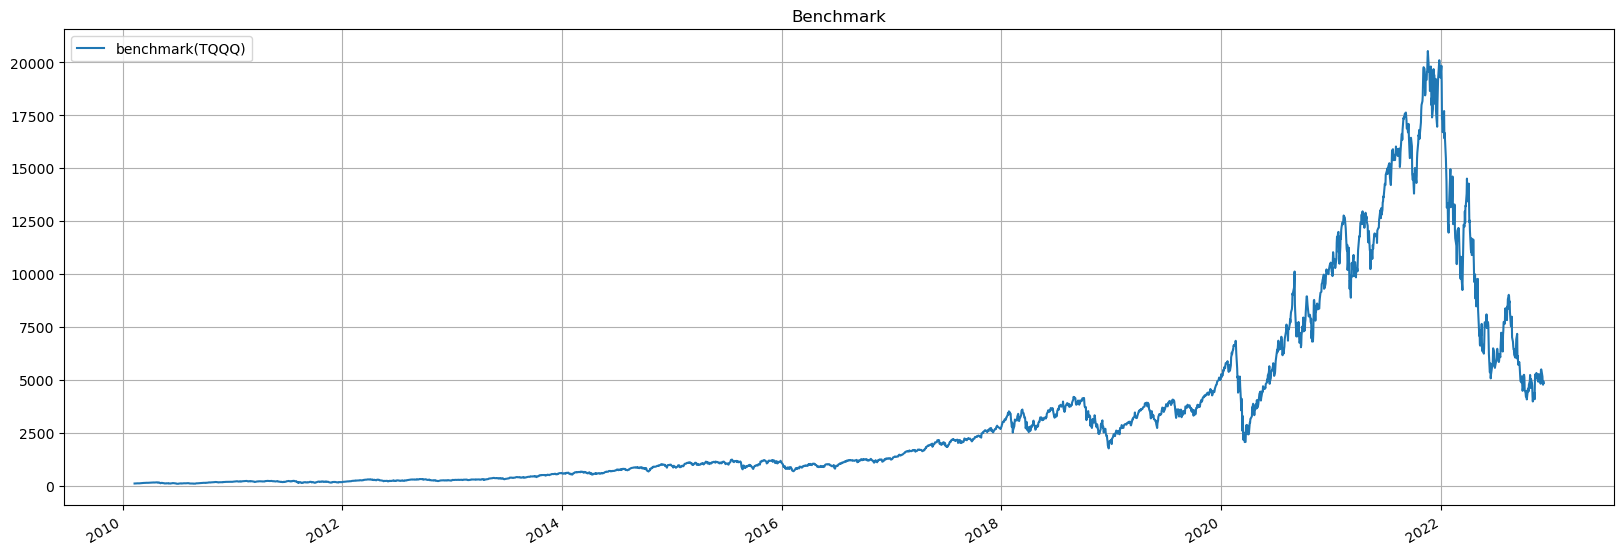

In [187]:
bm_report.plot(figsize=(20,7), grid=True, title="Benchmark")
print(bm_report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TMF)
-------------------  ----------------
Start                2010-02-11
End                  2022-12-09
Risk-free rate       0.00%

Total Return         40.10%
Daily Sharpe         0.28
Daily Sortino        0.47
CAGR                 2.66%
Max Drawdown         -87.19%
Calmar Ratio         0.03

MTD                  11.01%
3m                   -8.87%
6m                   -24.87%
YTD                  -66.44%
1Y                   -67.29%
3Y (ann.)            -29.16%
5Y (ann.)            -14.28%
10Y (ann.)           -6.34%
Since Incep. (ann.)  2.66%

Daily Sharpe         0.28
Daily Sortino        0.47
Daily Mean (ann.)    12.67%
Daily Vol (ann.)     44.78%
Daily Skew           0.01
Daily Kurt           3.74
Best Day             20.36%
Worst Day            -18.14%

Monthly Sharpe       0.25
Monthly Sortino      0.51
Monthly Mean (ann.)  10.15%
Monthly Vol (ann.)   40.84%
Monthly Skew         0.59
Monthly Kurt         0.72
Best Month           41.35%
Worst Mo

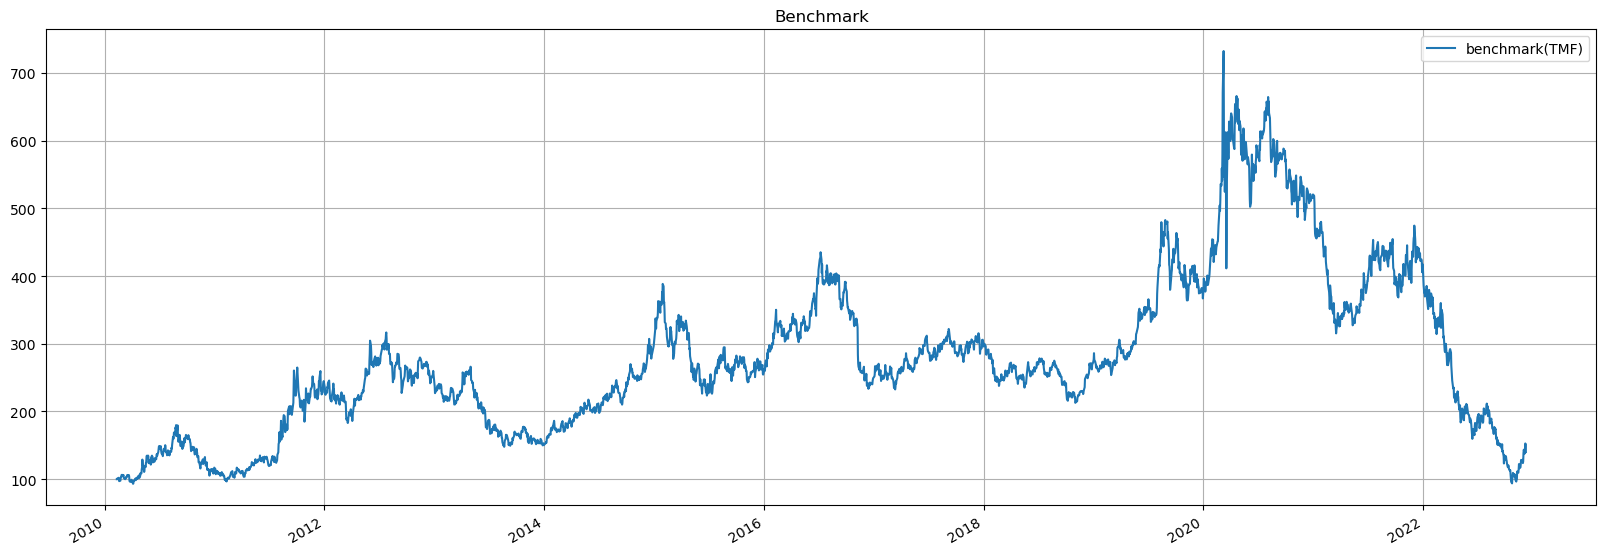

In [188]:
bm2_report.plot(figsize=(20,7), grid=True, title="Benchmark")
print(bm2_report.prices[start_day:].calc_stats().display())

In [189]:
bm_k = long_only_ew(assets_krw[tickers[0]].to_frame(), start_day, 'benchmark({}_krw)'.format(tickers[0]))
bm2_k = long_only_ew(assets_krw[tickers[1]].to_frame(), start_day, 'benchmark({}_krw)'.format(tickers[1]))

bm_k_report = bt.run(bm_k)
bm2_k_report = bt.run(bm2_k)

Stat                 benchmark(TQQQ_krw)
-------------------  ---------------------
Start                2010-02-11
End                  2022-12-12
Risk-free rate       0.00%

Total Return         5403.58%
Daily Sharpe         0.80
Daily Sortino        1.27
CAGR                 36.66%
Max Drawdown         -76.92%
Calmar Ratio         0.48

MTD                  -12.35%
3m                   -35.83%
6m                   -19.17%
YTD                  -72.34%
1Y                   -72.24%
3Y (ann.)            5.22%
5Y (ann.)            16.97%
10Y (ann.)           36.99%
Since Incep. (ann.)  36.66%

Daily Sharpe         0.80
Daily Sortino        1.27
Daily Mean (ann.)    49.31%
Daily Vol (ann.)     61.44%
Daily Skew           -0.30
Daily Kurt           6.49
Best Day             29.19%
Worst Day            -34.42%

Monthly Sharpe       0.86
Monthly Sortino      1.65
Monthly Mean (ann.)  43.93%
Monthly Vol (ann.)   50.91%
Monthly Skew         -0.14
Monthly Kurt         0.14
Best Month           

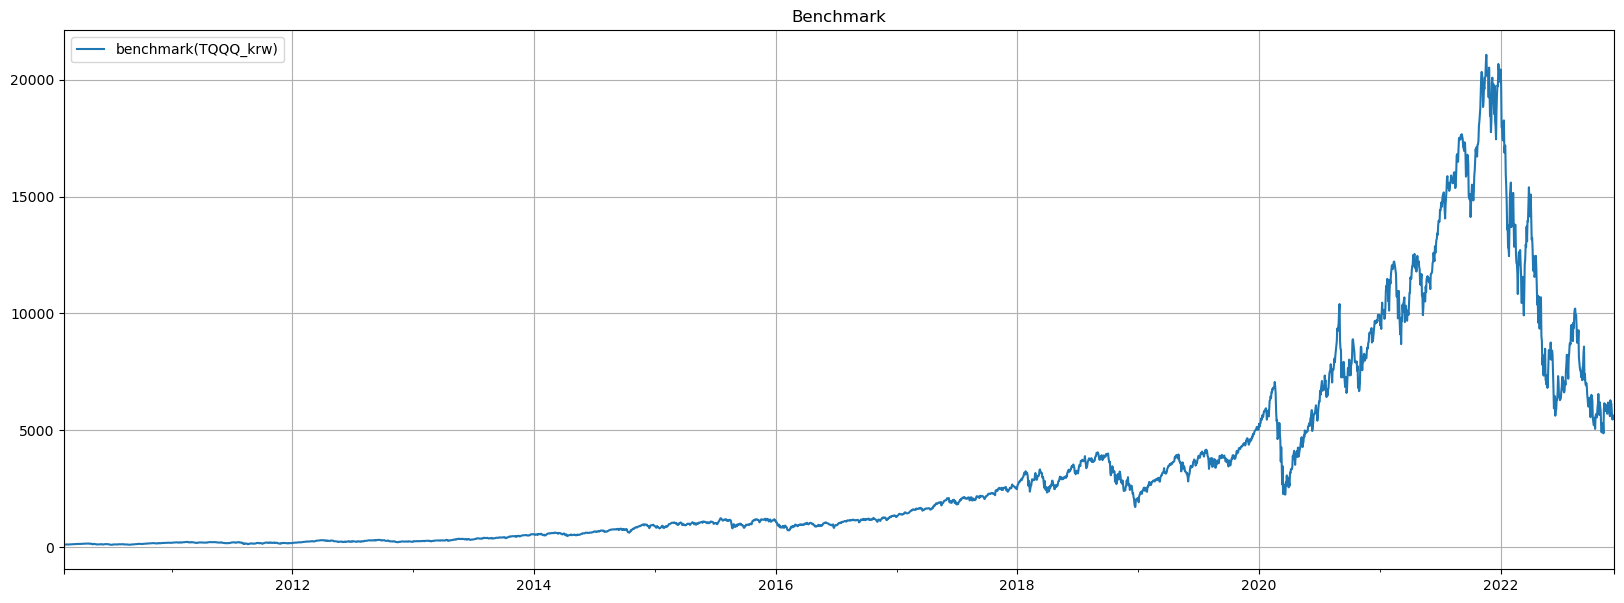

In [190]:
bm_k_report.plot(figsize=(20,7), grid=True, title="Benchmark")
print(bm_k_report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TMF_krw)
-------------------  --------------------
Start                2010-02-11
End                  2022-12-12
Risk-free rate       0.00%

Total Return         59.25%
Daily Sharpe         0.30
Daily Sortino        0.52
CAGR                 3.69%
Max Drawdown         -84.60%
Calmar Ratio         0.04

MTD                  9.74%
3m                   -11.18%
6m                   -20.68%
YTD                  -63.05%
1Y                   -63.25%
3Y (ann.)            -26.12%
5Y (ann.)            -10.98%
10Y (ann.)           -3.91%
Since Incep. (ann.)  3.69%

Daily Sharpe         0.30
Daily Sortino        0.52
Daily Mean (ann.)    13.91%
Daily Vol (ann.)     45.64%
Daily Skew           0.12
Daily Kurt           3.47
Best Day             20.51%
Worst Day            -17.75%

Monthly Sharpe       0.27
Monthly Sortino      0.61
Monthly Mean (ann.)  11.90%
Monthly Vol (ann.)   43.57%
Monthly Skew         1.03
Monthly Kurt         1.97
Best Month           55.23%


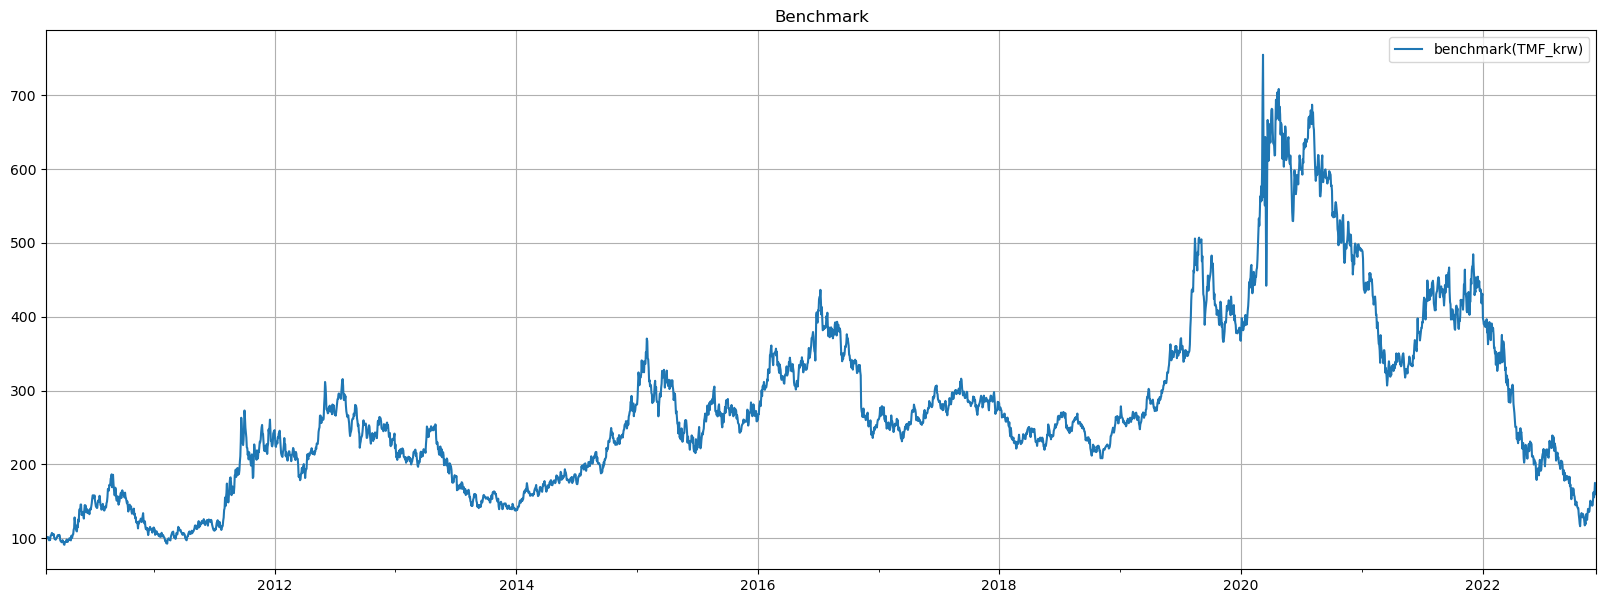

In [191]:
bm2_k_report.plot(figsize=(20,7), grid=True, title="Benchmark")
print(bm2_k_report.prices[start_day:].calc_stats().display())

In [192]:
def FixedWeight_BT(asset, start_day, weights, run_on_end_of_period=False, lag=1, name='Fixed Weighted'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           #bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.RunQuarterly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighSpecified(**weights),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [193]:
init=9
fixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10}
    print(weights)
    fixedWeights[i] = FixedWeight_BT(assets[tickers], start_day, weights, False, lag, name='FW_{}:{}'.format(init,(10-init)))
    init = init - 1
fw_report = bt.run(*fixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1}
{'TQQQ': 0.8, 'TMF': 0.2}
{'TQQQ': 0.7, 'TMF': 0.3}
{'TQQQ': 0.6, 'TMF': 0.4}
{'TQQQ': 0.5, 'TMF': 0.5}
{'TQQQ': 0.4, 'TMF': 0.6}
{'TQQQ': 0.3, 'TMF': 0.7}
{'TQQQ': 0.2, 'TMF': 0.8}
{'TQQQ': 0.1, 'TMF': 0.9}


<AxesSubplot:title={'center':'Fixed Weight'}>

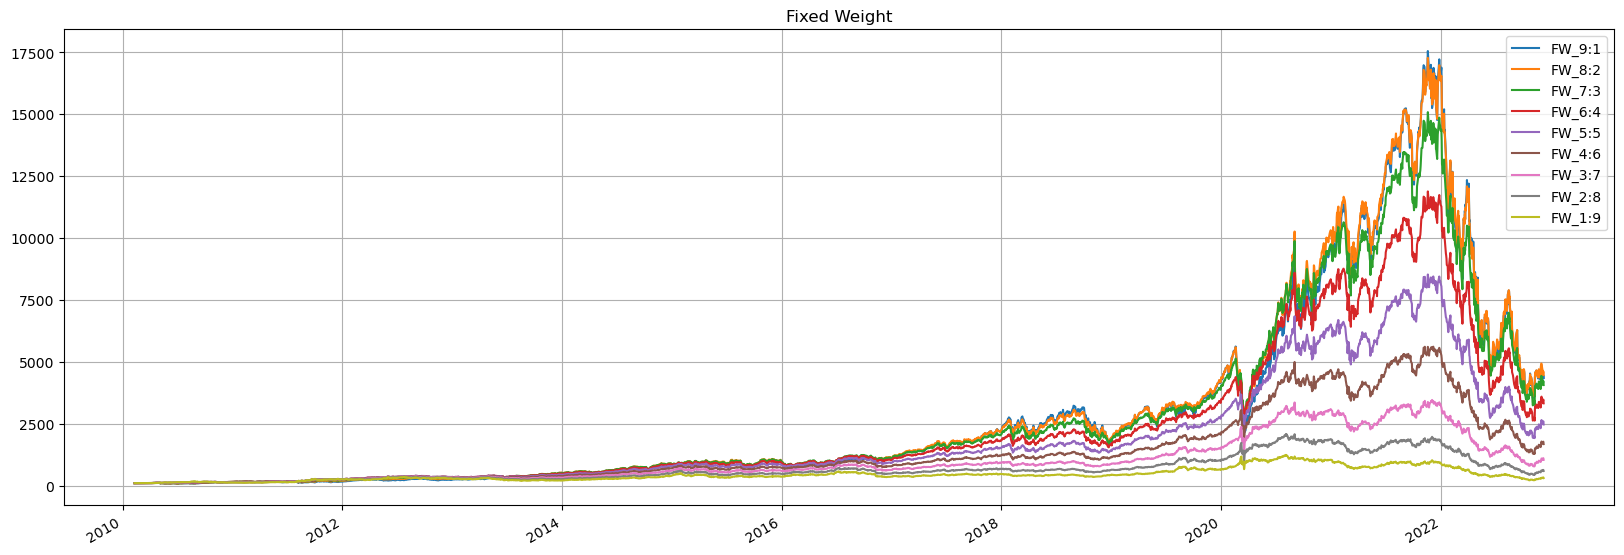

In [194]:
fw_report.plot(figsize=(20,7), grid=True, title="Fixed Weight")

In [195]:
fw_report.prices[start_day:].calc_stats().display()

Stat                 FW_9:1      FW_8:2      FW_7:3      FW_6:4      FW_5:5      FW_4:6      FW_3:7      FW_2:8      FW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         4238.91%    4362.82%    3959.14%    3220.79%    2367.94%    1575.02%    940.22%     490.50%     205.22%
Daily Sharpe         0.83        0.88        0.93        0.95        0.94        0.86        0.73        0.57        0.42
Daily Sortino        1.30        1.39        1.47        1.51        1.48        1.36        1.17        0.93        0.69

In [196]:
fw_report.backtests['FW_4:6'].stats.drawdown_details.sort_values('drawdown').head(20)

,Start,End,Length,drawdown
172,2021-12-08 00:00:00,2022-12-09 00:00:00,366,-0.771818
148,2020-03-10 00:00:00,2020-04-16 00:00:00,37,-0.42308
162,2020-09-03 00:00:00,2021-07-19 00:00:00,319,-0.313768
103,2016-09-07 00:00:00,2017-05-22 00:00:00,257,-0.260686
122,2018-08-31 00:00:00,2019-03-15 00:00:00,196,-0.235271
61,2013-05-03 00:00:00,2014-01-15 00:00:00,257,-0.226742
92,2015-02-03 00:00:00,2016-04-01 00:00:00,423,-0.210197
118,2018-01-29 00:00:00,2018-07-10 00:00:00,162,-0.191361
60,2012-09-04 00:00:00,2013-05-02 00:00:00,240,-0.167005
169,2021-09-16 00:00:00,2021-11-04 00:00:00,49,-0.164103


In [175]:
init=9
fixedWeights_krw = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10}
    print(weights)
    fixedWeights_krw[i] = FixedWeight_BT(assets_krw[tickers], start_day, weights, False, lag, name='FWK_{}:{}'.format(init,(10-init)))
    init = init - 1
fw_krw_report = bt.run(*fixedWeights_krw.values())

{'TQQQ': 0.9, 'TMF': 0.1}
{'TQQQ': 0.8, 'TMF': 0.2}
{'TQQQ': 0.7, 'TMF': 0.3}
{'TQQQ': 0.6, 'TMF': 0.4}
{'TQQQ': 0.5, 'TMF': 0.5}
{'TQQQ': 0.4, 'TMF': 0.6}
{'TQQQ': 0.3, 'TMF': 0.7}
{'TQQQ': 0.2, 'TMF': 0.8}
{'TQQQ': 0.1, 'TMF': 0.9}


<AxesSubplot:title={'center':'Fixed Weight'}>

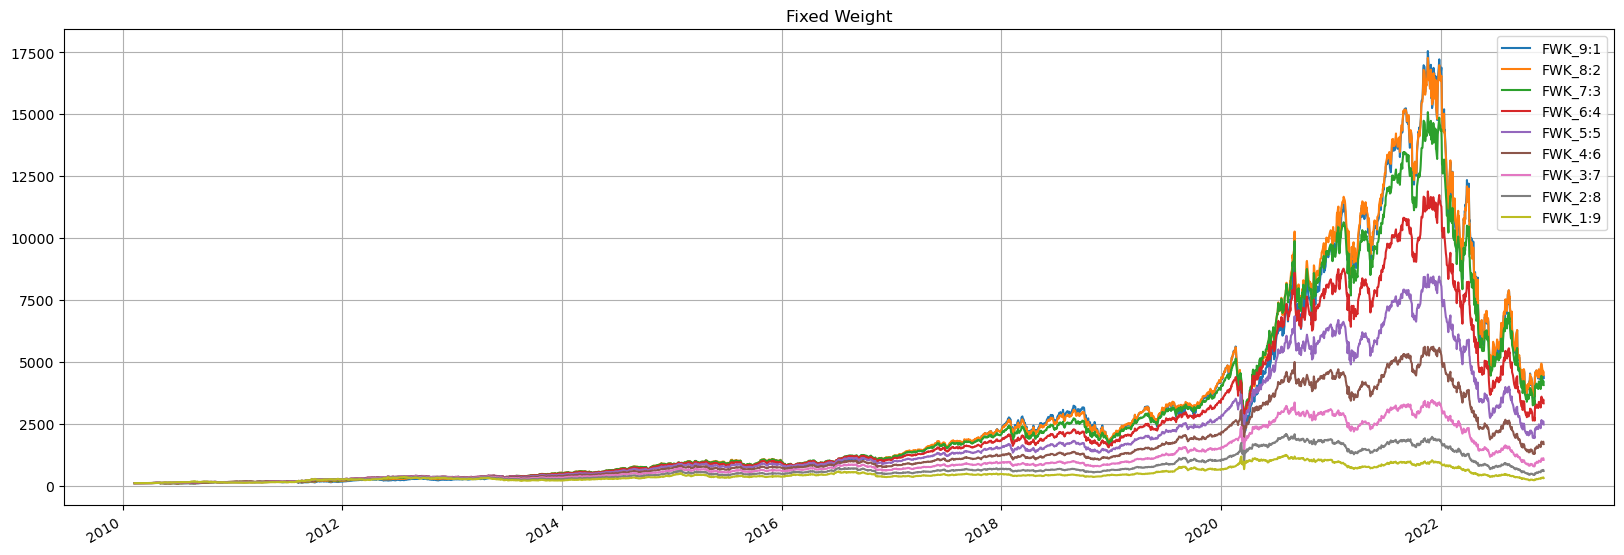

In [176]:
fw_krw_report.plot(figsize=(20,7), grid=True, title="Fixed Weight")

In [177]:
fw_krw_report.prices[start_day:].calc_stats().display()

Stat                 FWK_9:1     FWK_8:2     FWK_7:3     FWK_6:4     FWK_5:5     FWK_4:6     FWK_3:7     FWK_2:8     FWK_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         4238.91%    4362.82%    3959.14%    3220.79%    2367.94%    1575.02%    940.22%     490.50%     205.22%
Daily Sharpe         0.83        0.88        0.93        0.95        0.94        0.86        0.73        0.57        0.42
Daily Sortino        1.30        1.39        1.47        1.51        1.48        1.36        1.17        0.93        0.6

In [184]:
fw_krw_report.backtests['FWK_4:6'].stats.drawdown_details.sort_values('drawdown').head(20)

,Start,End,Length,drawdown
172,2021-12-08 00:00:00,2022-12-09 00:00:00,366,-0.771818
148,2020-03-10 00:00:00,2020-04-16 00:00:00,37,-0.42308
162,2020-09-03 00:00:00,2021-07-19 00:00:00,319,-0.313768
103,2016-09-07 00:00:00,2017-05-22 00:00:00,257,-0.260686
122,2018-08-31 00:00:00,2019-03-15 00:00:00,196,-0.235271
61,2013-05-03 00:00:00,2014-01-15 00:00:00,257,-0.226742
92,2015-02-03 00:00:00,2016-04-01 00:00:00,423,-0.210197
118,2018-01-29 00:00:00,2018-07-10 00:00:00,162,-0.191361
60,2012-09-04 00:00:00,2013-05-02 00:00:00,240,-0.167005
169,2021-09-16 00:00:00,2021-11-04 00:00:00,49,-0.164103


In [179]:
print(assets)

                 TQQQ        TMF
Date                            
2010-02-11   0.431471   6.695423
2010-02-12   0.433238   6.771189
2010-02-16   0.450019   6.831799
2010-02-17   0.457656   6.613167
2010-02-18   0.466332   6.500600
...               ...        ...
2022-12-05  22.230000   9.230000
2022-12-06  20.820000   9.590000
2022-12-07  20.570000  10.230000
2022-12-08  21.299999  10.160000
2022-12-09  20.889999   9.380000

[3231 rows x 2 columns]


In [182]:
print(assets_krw[tickers])

                    TQQQ           TMF
Date                                  
2010-02-11    497.313624   7717.144532
2010-02-12    498.570003   7792.284328
2010-02-15    496.663746   7762.490932
2010-02-16    515.361330   7823.775916
2010-02-17    525.159743   7588.608913
...                  ...           ...
2022-12-06  27156.982900  12508.908452
2022-12-07  27146.433494  13500.632296
2022-12-08  27990.328477  13351.255551
2022-12-09  27504.399998  12349.989596
2022-12-12  27370.076180  12289.675692

[3348 rows x 2 columns]
